ProtBert se basa en el modelo Bert*, preentrenado con un amplio corpus de secuencias de proteínas de forma autosupervisada. Esto significa que se preentrenó únicamente con las secuencias de proteínas sin procesar, sin etiquetado humano (por lo que puede usar una gran cantidad de datos públicos) con un proceso automático para generar entradas y etiquetas a partir de dichas secuencias ---> Fue entrenado con secuencias tomadas de UniProt. (https://huggingface.co/Rostlab/prot_bert)
*nota: Modelo Bert 
BERT es unmodelo de lenguaje desarrollado por Google para el procesamiento del lenguaje natural (PLN) que se destaca por su enfoque bidireccional, considerando tanto el contexto anterior como el posterior de una palabra para entender su significado. 
Se basa en la predicción de Ontología génica (GO: Vocabulario estandarizado utilizado para describir las funciones de las proteínas de manera consistente en diferentes bases de datos: Función molecular, proceso biológico y componente celular https://geneontology.org/docs/ontology-documentation/). 
Se entrenó a partir de aprox 106 M de proteínas 
1. Modelado bidireccional: el embedding de cada proteína captura patronems locales y globales:
   1.1. Local: predicción de a.a. o motivos
   1.2. Global: GO, es decir, predecir la función
2. Codificación de las secuencia y anotaciones:
   2.1. Se tienen 26 tokens* que corresponden a los 20 a.a. + END (Para indicar el final) + START (Para indicar el inicio) + PAD (se     utiliza para "rellenar" espacios y que las secuencias que tengan menos aa queden del mismo tamaño)
   *Token: Unidad básica de entrada que el modelo puede entender.
   Por ejemplo:
   Secuencia 1: START M K V I END
   Secuencia 2: START A L I ENDA PAD--------> Así se tiene un mini batch de longitud fija.
3. Finalmente se agrega la GO de forma binaria.
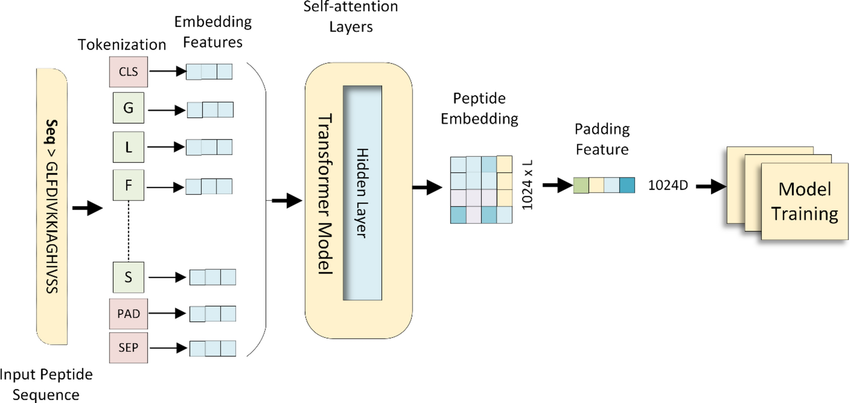!

Nadav Brandes, Dan Ofer, Yam Peleg, Nadav Rappoport, Michal Linial, ProteinBERT: a universal deep-learning model of protein sequence and function, Bioinformatics, Volume 38, Issue 8, March 2022, Pages 2102–2110, https://doi.org/10.1093/bioinformatics/btac020



Librerias utilizadas (:
pandas: manejar y guardar datos.
SeqIO: cargar secuencias biológicas, permite trabajar con diferentes formatos de archivo comunes en bioinformática y utilizar el objeto SeqRecordpara representar los datos de secuencia. 
BertTokenizer + BertModel: transformar secuencias en embeddings con ProtBert.
torch: backend para cálculos y uso de GPU/CPU.

In [1]:
import pandas as pd
from Bio import SeqIO
from transformers import BertTokenizer, BertModel
import torch

Aquí solo utilice 100 secuencias para probar (:

In [2]:
fasta_p = "/Users/ingridreyes/Desktop/protein_sequences_50000.fasta"
fasta_f = list(SeqIO.parse(fasta_p, "fasta"))

1. Elegir el modelo de Hugging Face: protbert_model_name = "Rostlab/prot_bert" Nombre del checkpoint público que vamos a cargar (el ProtBert original del grupo Rostlab).
3. Cargar el tokenizer:  protbert_tokenizer = BertTokenizer.from_pretrained(protbert_model_name, do_lower_case=False)
   do_lower_case=False no convierte a minúsculas. En proteínas las letras en mayúscula representan aminoácidos.
4. Cargar el modelo ProtBert: protbert_model = BertModel.from_pretrained(protbert_model_name): Descarga los pesos del Transformer ya preentrenado. Este modelo, dado un lote de tokens, devuelve tensores con los embeddings contextualizados (salidas de las capas de atención).
5. device = torch.device("mps" if torch.backends.mps.is_available() else "cpu"): para que traaje con mps de mac
6. protbert_model.to(device): Pasa todos los pesos del modelo a GPU (MPS) y se ejecuten ahí.

In [3]:
#https://github.com/huggingface/transformers/issues/981
protbert_model_name = "Rostlab/prot_bert"  #https://huggingface.co/Rostlab/prot_bert
protbert_tokenizer = BertTokenizer.from_pretrained(protbert_model_name, do_lower_case=False)
protbert_model = BertModel.from_pretrained(protbert_model_name)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
protbert_model.to(device) 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

1. Divide las secuencias en lotes.
2. Convierte cada secuencia en formato compatible con ProtBert.
3. Tokeniza y mueve a GPU/CPU.
4. Obtiene embeddings promedio de cada secuencia sin calcular gradientes.
5. Guarda los embeddings y las secuencias.
6. Devuelve todas las secuencias y embeddings concatenados.

Glosario: https://huggingface.co/docs/transformers/en/glossary

In [4]:
def protbert_batch_embeddings(records, batch_size=4): 
    embeddings = [] #embeddings: lista donde se guardarán los vectores (embeddings) resultantes de ProtBert.
#sequences_list: lista donde se guardarán las secuencias de aminoácidos originales (para poder identificarlas después).
    sequences_list = []

    #se hace un buvle de los en el que se recorre records
    #es la lista de datos de entrada que contiene las secuencias de proteínas que quieres transformar en embeddings con ProtBert.
    #en lotes
    for i in range(0, len(records), batch_size): 
        batch = records[i:i+batch_size] 
        #range(0, len(records), batch_size): se crea una secuencia de números que comienza en 0, termina antes de len(records) 
        #(la longitud de la lista llamada records), y se incrementa en batch_size en cada paso.
        #i: En cada iteración del bucle, la variable i toma el siguiente valor de la secuencia generada por range().
        #len(records): Determina el límite superior del rango, asegurando que el bucle no exceda la longitud de records.
        #batch_size: Define el tamaño del "batch" o grupo. 
        sequences = [" ".join(list(str(r.seq))) for r in batch]  # Espacios entre aminoácidos
        #for r in batch: Itera a través de cada elemento r en la lista batch. 
        #cada r tiene un atributo llamado seq que contiene la secuencia de aminoácidos.
        #str(r.seq): Convierte la secuencia r.seq a una cadena (string).
        #list(str(r.seq)): Convierte la cadena de aminoácidos en una lista de caracteres, donde cada carácter representa un aminoácido.
        #" ".join(...): Toma la lista de aminoácidos y los une en una sola cadena, insertando un espacio (" ") entre cada aminoácido.
       
        #Aquí empieza la tokenización
        #https://github.com/huggingface/candle/issues/1552
        encoding = protbert_tokenizer(sequences, return_tensors='pt', padding=True, truncation=True)
        #de una lusta de secuencias las convierte con return_tensors='pt' a tensores de PyTorch. 
        #padding=True asegura que todas las secuencias tengan la misma longitud añadiendo tokens de relleno. 
        #truncation=True trunca las secuencias que son demasiado largas.
        input_ids = encoding['input_ids'].to(device)
        #Esta línea extrae los IDs de los tokens (input_ids) del diccionario encoding y los mueve al dispositivo especificado (CPU o GPU, definido por la variable device). Los input_ids son la representación numérica de las palabras o sub-palabras en las secuencias.
        attention_mask = encoding['attention_mask'].to(device)
        #extrae la máscara de atención (attention_mask) del diccionario encoding y la mueve al dispositivo especificado. 
        #La máscara de atención indica qué tokens deben ser atendidos y cuáles deben ser ignorados (por ejemplo, los tokens de relleno).
        
        with torch.no_grad(): #desactiva el cálculo de gradientes durante la ejecución. Esto es importante porque estamos en una fase de inferencia (predicción), no de entrenamiento
            outputs = protbert_model(input_ids=input_ids, attention_mask=attention_mask)
            #input_ids: Son los IDs numéricos que representan las secuencias de aminoácidos de las proteínas. 
            #Estos IDs son el resultado de un proceso de tokenización, donde cada aminoácido se mapea a un número entero.
            #Es una máscara que indica qué tokens son "reales" y cuáles son padding (relleno).
            #Este objeto contiene varias salidas, pero en este caso nos interesa last_hidden_state---> Secuencia de estados ocultos en la salida de la última capa del decodificador.
            batch_embeds = outputs.last_hidden_state.mean(dim=1).cpu()  # embedding promedio
            #outputs.last_hidden_state: Es la última capa oculta del modelo ProtBERT. Tiene una forma (batch_size, sequence_length, hidden_size).
            #.mean(dim=1): Calcula el promedio de los hidden states a lo largo de la dimensión de la secuencia (dim=1). Esto significa que, para cada secuencia en el batch, se calcula el promedio de los embeddings de todos sus aminoácidos. El resultado es un embedding de longitud fija para cada proteína, independientemente de su longitud original. Esto es útil para comparar proteínas de diferentes longitudes. La forma resultante es (batch_size, hidden_size).
       
        embeddings.append(batch_embeds) #embeddings.append(batch_embeds): Esta línea agrega una variable llamada batch_embeds a una lista llamada embeddings.
        sequences_list.extend([str(r.seq) for r in batch])  # 
    
    embeddings = torch.cat(embeddings, dim=0)
    #torch.cat(embeddings, dim=0): une todos los embeddings de los lotes en un solo tensor.
    return sequences_list, embeddings
#la funcuon devukeve sequences_list: lista de secuencias originales
#embeddings: tensor con los embeddings finales correspondientes a cada secuencia.

In [5]:
seqs, prot_embeddings = protbert_batch_embeddings(fasta_f, batch_size=4)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RuntimeError: Invalid buffer size: 15.14 GiB

In [ ]:
prot_df = pd.DataFrame(prot_embeddings.numpy(), index=seqs)
prot_df.to_csv("/Users/ingridreyes/Desktop/embeddings_50000_prot_seq.csv")